# Explorative Datenanalyse der Kriminalität in Chicago
----

# Konfiguration

In [78]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [6]:
%%time

dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

crimes = pd.read_csv(f"data/crimes.csv", parse_dates=['Date', 'Updated On'], date_parser=dateparse)

CPU times: user 3min 2s, sys: 4.12 s, total: 3min 6s
Wall time: 3min 6s


In [7]:
crimes.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,2018-02-10 15:50:01,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,2015,2018-02-10 15:50:01,41.773372,-87.665319,"(41.773371528, -87.665319468)"


# Cleaning

In [87]:
crimes = crimes[crimes['Primary Type'] != 'DOMESTIC VIOLENCE']

# Häufigkeit pro Straftatenart

In [274]:
crimes.groupby(crimes['Primary Type']).size().sort_values(ascending=False)

Primary Type
THEFT                                1417696
BATTERY                              1232015
CRIMINAL DAMAGE                       771356
NARCOTICS                             710760
OTHER OFFENSE                         418441
ASSAULT                               418375
BURGLARY                              387936
MOTOR VEHICLE THEFT                   314156
DECEPTIVE PRACTICE                    262300
ROBBERY                               255578
CRIMINAL TRESPASS                     193342
WEAPONS VIOLATION                      70639
PROSTITUTION                           68322
PUBLIC PEACE VIOLATION                 47775
OFFENSE INVOLVING CHILDREN             45301
CRIM SEXUAL ASSAULT                    27075
SEX OFFENSE                            25081
INTERFERENCE WITH PUBLIC OFFICER       15136
GAMBLING                               14422
LIQUOR LAW VIOLATION                   14061
ARSON                                  11151
HOMICIDE                                94

# Verhaftungsraten

> Enden gewaltsame Straftaten überproportional oft in Verhaftungen?

In [268]:
c = crimes
c = c.groupby(['Primary Type', 'Arrest']).size().sort_values(ascending=False)
c = c.unstack()
c['Total'] = c[False] + c[True]
c = c.sort_values(ascending=False, by='Total')
c = (c[True] / (c[True] + c[False]))
arrest_percent = c.sort_values(ascending=False)


### Hohe Verhaftungsrate

In [178]:
x = arrest_percent.astype(float).map("{:.2%}".format).head(12)
pd.DataFrame({'Description':x.index, 'Probability of Arrest':x.values})

,Description,Probability of Arrest
0,PROSTITUTION,99.60%
1,NARCOTICS,99.41%
2,PUBLIC INDECENCY,99.38%
3,GAMBLING,99.28%
4,LIQUOR LAW VIOLATION,99.10%
5,CONCEALED CARRY LICENSE VIOLATION,93.29%
6,INTERFERENCE WITH PUBLIC OFFICER,91.72%
7,OBSCENITY,82.76%
8,WEAPONS VIOLATION,79.58%
9,CRIMINAL TRESPASS,73.25%


### Niedrige Verhaftungsrate

In [177]:
x = arrest_percent.astype(float).map("{:.2%}".format).tail(12)
pd.DataFrame({'Description':x.index, 'Probability of Arrest':x.values})

,Description,Probability of Arrest
0,CRIM SEXUAL ASSAULT,15.66%
1,RITUALISM,13.04%
2,ARSON,13.02%
3,HUMAN TRAFFICKING,12.24%
4,THEFT,11.95%
5,KIDNAPPING,11.12%
6,ROBBERY,9.70%
7,MOTOR VEHICLE THEFT,9.13%
8,CRIMINAL DAMAGE,7.06%
9,NON-CRIMINAL,6.13%


### Verhaftungsraten: Diebstahl

In [199]:
c = crimes
c = c[c['Primary Type'] == 'THEFT']
c = c.set_index('Description').sort_index()
c = c.groupby(['Description', 'Arrest']).size().sort_values(ascending=False).unstack()
c['Total'] = c[False] + c[True]
c = c.sort_values(ascending=False, by='Total')
c.drop('Total', axis=1)
c = (c[True] / (c[True] + c[False]))
c = c.sort_values(ascending=False)

c = c.astype(float).map("{:.2%}".format).rename('wfj')

df = pd.DataFrame({'Description':c.index, 'Probability of Arrest':c.values})

In [200]:
df

,Description,Probability of Arrest
0,RETAIL THEFT,60.43%
1,ATTEMPT THEFT,24.89%
2,DELIVERY CONTAINER THEFT,22.10%
3,FROM COIN-OP MACHINE/DEVICE,16.54%
4,$500 AND UNDER,7.95%
5,OVER $500,3.87%
6,AGG: FINANCIAL ID THEFT,3.17%
7,FROM BUILDING,2.66%
8,PURSE-SNATCHING,2.58%
9,POCKET-PICKING,2.02%


In [201]:
df[(df.Description == ('$500 AND UNDER')) | (df.Description == ('OVER $500'))]

,Description,Probability of Arrest
4,$500 AND UNDER,7.95%
5,OVER $500,3.87%


Mögliche Eklärungen: 
- Wertvollere Gegenstände sind eher/besser versichert
- Diebstahl wertvoller Gegenstände ist besser geplant / Affekthandlung bei günstigen Gegenständen

### Verhaftungsraten: Drogen

In [238]:
c = crimes
c = c[c['Primary Type'] == 'NARCOTICS']
c = c.set_index('Description').sort_index()
c = c.groupby(['Description', 'Arrest']).size().sort_values(ascending=False).unstack()
c['Total'] = c[False] + c[True]
c = c.sort_values(ascending=False, by='Total')
c.drop('Total', axis=1)
c = (c[True] / (c[True] + c[False]))
c = c.sort_values(ascending=False)

c = c.astype(float).dropna()
p = c.map("{:.2%}".format)

df = pd.DataFrame({'Description':p.index, 'Probability of Arrest':p.values})
df.head(5).append(df.tail(5))

,Description,Probability of Arrest
0,POSS: PCP,99.80%
1,ATTEMPT POSSESSION NARCOTICS,99.71%
2,SOLICIT NARCOTICS ON PUBLICWAY,99.60%
3,POSS: BARBITUATES,99.60%
4,POS: HYPODERMIC NEEDLE,99.56%
37,MANU/DELIVER: HALLUCINOGEN,97.84%
38,DELIVER CANNABIS TO PERSON <18,97.78%
39,CRIMINAL DRUG CONSPIRACY,96.90%
40,CALCULATED CANNABIS CONSPIRACY,83.33%
41,FAIL REGISTER LIC:CONT SUBS,80.00%


In [258]:
print(f'Standard Abweichung der Verhaftungsrate von verschiedenen Drogendeliktarten:\n{"%.3f" % c.std()}')

Standard Abweichung der Verhaftungsrate von verschiedenen Drogendeliktarten:
0.038


Die Art des Drogendeliktes hat anscheinend keinen Einfluss auf die Verhaftungsrate. 

# Zeit & Datum

In [9]:
crimes.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,2018-02-10 15:50:01,41.891399,-87.744385,"(41.891398861, -87.744384567)"


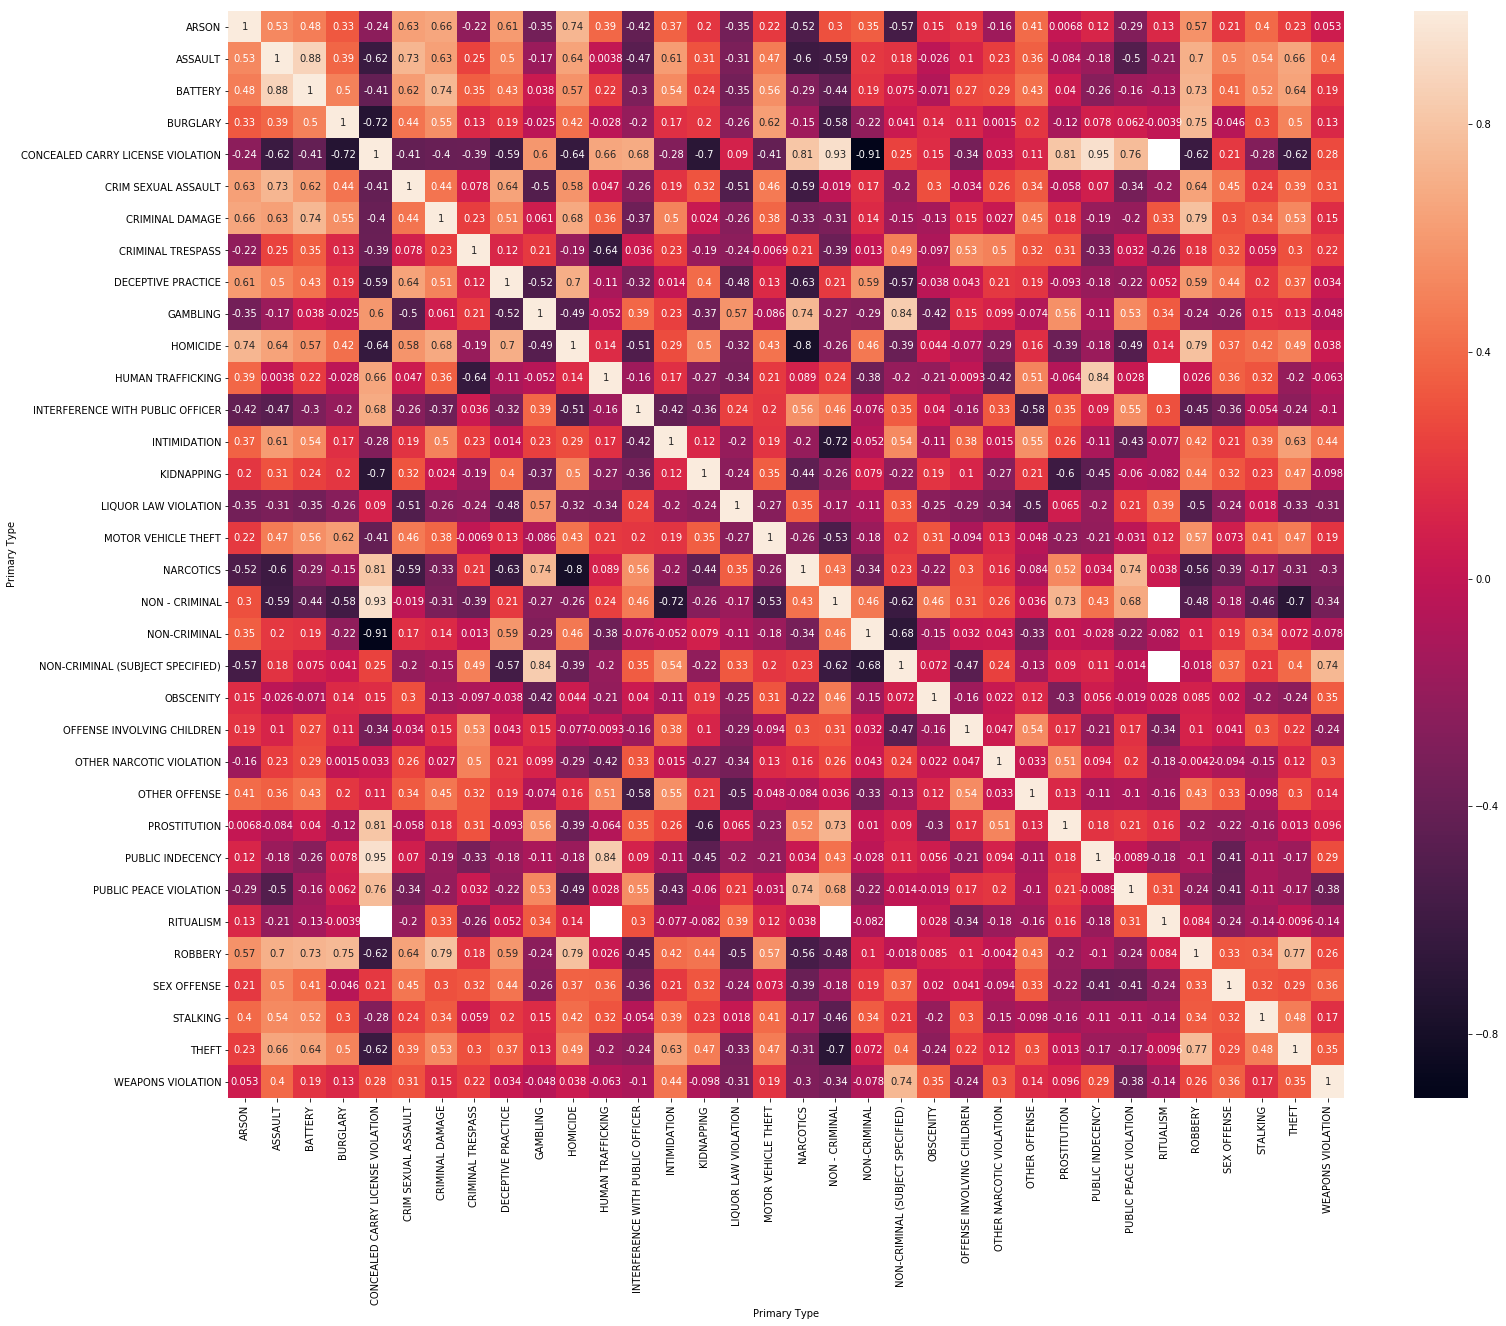

In [88]:
c = crimes

types = ['NARCOTICS', 'PROSTITUTION', 'THEFT', 'MOTOR VEHICLE THEFT', 'BURGLARY', 'CRIMINAL TRESPASS', 'GAMBLING', 'LIQUOR LAW VIOLATION']
c = c.groupby([c.Date.dt.year.astype(int), c['Primary Type']]).size()
c = c.unstack()
#c['Total Crime Count'] = c.sum(axis=1)
#c = c[types]
c = c.pct_change()

c = c.corr()
plt.subplots(figsize=(25,20))
sns.heatmap(c, annot=True)